## Setup

In [42]:
from functions import Model, get99, splitData, dropMissingValues, z_score, outliers_knn, outliers_dbscan, getNoise, getRelFeatures, drop_features, getCombinations, get_unique_list, bold, blue, red, green, getBestModel, np_to_df, df_to_np, drop99_all, z_score_individual, train_test_to_df, loadModel
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

warnings.filterwarnings('ignore')

## Testdata

Get Test Data from CSV

In [43]:
#Get test Data
NAME_TEST_FILE = "house_data_testing"
df_test_data = pd.read_csv("data/csv/"+NAME_TEST_FILE+".csv", sep=';') 

# remove unnamed column
df_test_data = df_test_data.iloc[:, 1:]

#Transform string to datetime
try: 
    df_test_data["date"] = pd.to_datetime(df_test_data["date"])
except Exception as e:
    print("Error: Trying to convert to date")

Drop Missing Values

In [44]:
print(f'There are {blue(df_test_data.isnull().sum().sum())} Missing Values')
df_test_data = dropMissingValues(df_test_data) 

There are 8 Missing Values


Drop Values with 999..99 

In [45]:
try:
    outlier_list_99 = get99(df_test_data) 
    df_test_data = drop99_all(df_test_data, outlier_list_99)
    print(green('99s dropped'), "\n")
except Exception as e:
    pass

99s dropped 



In [46]:
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 613
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             597 non-null    int64         
 1   date           597 non-null    datetime64[ns]
 2   price          597 non-null    float64       
 3   bedrooms       597 non-null    int64         
 4   bathrooms      597 non-null    float64       
 5   sqft_living    597 non-null    int64         
 6   sqft_lot       597 non-null    int64         
 7   floors         597 non-null    float64       
 8   waterfront     597 non-null    float64       
 9   dis_super      597 non-null    float64       
 10  view           597 non-null    float64       
 11  condition      597 non-null    float64       
 12  grade          597 non-null    float64       
 13  sqft_above     597 non-null    float64       
 14  sqft_basement  597 non-null    float64       
 15  yr_built       597 non-

##

## Model

Get saved Model from Grid-Search

In [47]:
model_obj = loadModel()

Model: GradientBoostingRegressor(random_state=1) Combination: ('outlier_list_z_score_ind_',) Features: 23


Making sure Shapes are similar

In [48]:
print(f'Training Data Features: {blue(len(model_obj.get_features()))}')
print(f'Testing Data Features: {blue(len(df_test_data.columns.to_list()))}')

features_to_drop = list(set(df_test_data.columns.to_list()) - set(model_obj.get_features()))
print(f'Features to drop from Testdata: {red(features_to_drop)}')

Training Data Features: 23
Testing Data Features: 25
Features to drop from Testdata: ['price', 'date']


Integrate test Data into Model

In [49]:
X_train, X_test, y_train, y_test = model_obj.get_data()

#Drop Features
X_test, y_test = df_test_data.drop(columns=features_to_drop), df_test_data["price"]

#Tranform Test-Data
if isinstance(model_obj.get_model(), Lasso) == True:
    scaler = StandardScaler().fit(X_test)
    X_test = scaler.transform(X_test)

model_obj.set_data(X_train, X_test, y_train, y_test)

#Train Model
model_obj.train()

#Predict
mae, score = model_obj.summary()
predictions = model_obj.pred()

In [50]:
#Evaluate
df_test_data["price_pred"]  = predictions
df_test_data["diff"] = df_test_data["price"]  - df_test_data["price_pred"]  
df_test_data.loc[:, ["price", "price_pred", "diff"]].T.applymap('{:,.2f}'.format)

,0,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,612,613
price,"336,000.00","1,600,000.00","460,000.00","998,500.00","745,000.00","325,000.00","810,000.00","677,000.00","600,000.00","412,450.00",...,"473,000.00","343,566.00","550,000.00","387,500.00","500,000.00","739,000.00","710,000.00","475,000.00","340,000.00","475,000.00"
price_pred,"323,749.85","1,346,074.66","440,545.34","751,893.87","711,451.48","295,468.52","734,766.85","625,377.65","601,650.23","583,278.14",...,"558,986.88","278,394.12","560,775.16","436,646.93","641,070.88","688,631.03","633,931.89","476,708.64","386,966.58","473,912.24"
diff,"12,250.15","253,925.34","19,454.66","246,606.13","33,548.52","29,531.48","75,233.15","51,622.35","-1,650.23","-170,828.14",...,"-85,986.88","65,171.88","-10,775.16","-49,146.93","-141,070.88","50,368.97","76,068.11","-1,708.64","-46,966.58","1,087.76"


In [54]:
#df_test_data.loc[:, ["price", "price_pred", "diff"]].describe().T.applymap('{:,.2f}'.format)

## Visulize Predictions

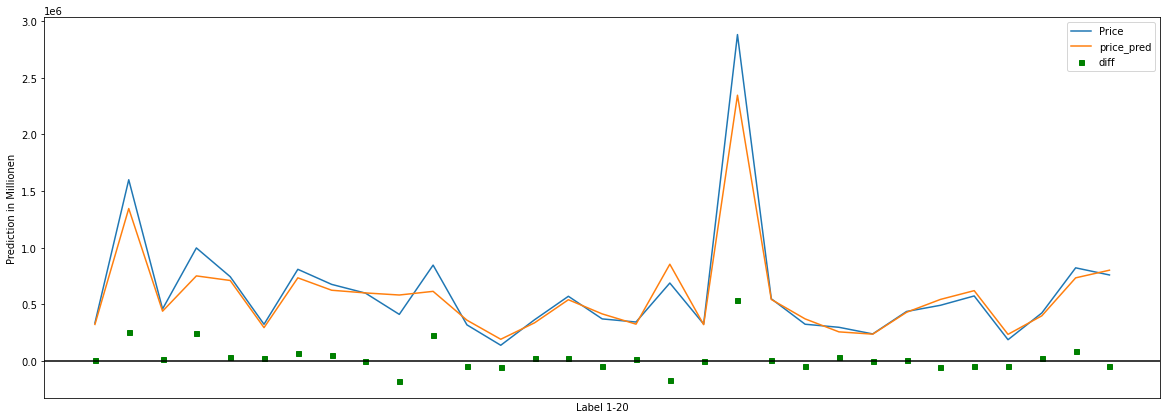

In [59]:
plt.figure(figsize=(20,7))
#Prediction der Modelle für die ersten 20 Zeilen
x = 30
real = df_test_data.loc[:x, "price"]
pred = df_test_data.loc[:x,"price_pred"]
diff = df_test_data.loc[:x,"diff"]

plt.plot(real, label="Price")
plt.plot(pred, label="price_pred")
plt.plot(diff, "gs", ms=5, label="diff")
plt.axhline(y=0, color='black', linestyle='-')

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Prediction in Millionen")
plt.xlabel("Label 1-20")
plt.legend(loc="best")

plt.show()

In [53]:
print(bold("MAE: "), blue(mae))

MAE:  70301.43
